# Dog Name Generator
A character level RNN to generate dog names. Trained on the top 500 dog names.

Thanks to the PyTorch tutorials [https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html]  and the Coursera Deep Learning class [https://www.coursera.org/learn/nlp-sequence-models] for the inspiration (and much of the code).


In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import numpy as np
torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Do some preprocessing
- import the data
- clean it up a bit
- Get the data as lines


### Import data

In [6]:
text = open('top_500_dog_names.txt').read()
text = text.lower()
text = text.replace('\t', '')

chars = list(set(text))

In [7]:
lines = text.split('\n')
lines = list(filter(None, lines))

### Create mappings

In [8]:
# make some dictionaries so you can select each character and index from each other
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

## Define the NN Architecture

We're going to take the architecture defined in the PyTorch examples, with a couple of tweaks. We'll replace the Linear layers with some GRUs, and we are removing the input of "category", since we won't be generating from a category.

In [10]:

class RNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = torch.nn.GRUCell(input_size + hidden_size, hidden_size)
        self.i2o = torch.nn.GRUCell(input_size + hidden_size, output_size)
        self.o2o = torch.nn.Linear(hidden_size + output_size, output_size)
        self.dropout = torch.nn.Dropout(0.25)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output_combo = torch.cat((hidden, output),1)
        output = self.o2o(output_combo)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
n_letters = len(chars)

rnn = RNN(len(chars), n_hidden, len(chars))

In [11]:
rnn.cuda()

RNN(
  (i2h): GRUCell(155, 128)
  (i2o): GRUCell(155, 27)
  (o2o): Linear(in_features=155, out_features=27, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (softmax): LogSoftmax()
)

In [74]:
#helper function to choose a random line
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [75]:
def randomLine(your_list):
    return your_list[random.randint(0, len(your_list)-1)]

In [76]:
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, len(chars))
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][char_to_ix.get(letter)]=1
    return tensor
        
def targetTensor(line):
    letter_indices = [char_to_ix.get(line[li]) for li in range(1, len(line))]
    letter_indices.append(char_to_ix.get('\n'))
    return torch.cuda.LongTensor(letter_indices)

In [77]:
print(inputTensor(lines[0]).shape)

print(targetTensor(lines[0]))
print(lines[0])

torch.Size([4, 1, 27])
tensor([ 6,  6,  5, 17])
abby


In [78]:
criterion = torch.nn.NLLLoss()
lr = 0.001
opt = torch.optim.Adam(rnn.parameters(), lr=lr)


def train(input_line_tensor, target_line_tensor):
    # make sure the input is 3d by adding a single dim at the end
    # use underscore for 'inplace'
    target_line_tensor.unsqueeze_(-1)
    
    # initialize the hidden parameters
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    #do forward propagation for each letter in the line
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        #because we predict at every step, we calculate loss every step
        curr_loss = criterion(output, target_line_tensor[i])
#         print('crit', l,'total_loss',loss,'target',target_line_tensor[i])
        loss += curr_loss
    
    if type(loss)==int:
        print(loss, input_line_tensor)
    loss.backward()
    _ = torch.nn.utils.clip_grad_norm_(rnn.parameters(), 50.0)
    opt.step()
    # add the params
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-lr)
        
    return output, loss.item()/input_line_tensor.size(0)


In [79]:
n_iter = 100000
print_every = 10000
plot_every = 5000
all_losses = []
total_loss = 0 #reset when you plot

for i in range(1, n_iter+1):
    #get a random line to predict on
    training_example = randomLine(lines)
    
    #get a tensor from your lines
    input_tensor = inputTensor(training_example)
    target_tensor = targetTensor(training_example)
    
#     print(training_example)
    output, loss = train(input_tensor, target_tensor)
    
    total_loss+=loss
    
    if i%print_every==0:
        print(i, loss)
    
    if i%plot_every==0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0


10000 1.2072434425354004
20000 1.542169213294983
30000 1.1762464046478271
40000 1.5749554634094238
50000 1.6325790087382
60000 2.369881820678711
70000 0.9134089946746826
80000 0.1989816427230835
90000 0.712247371673584
100000 1.166590118408203


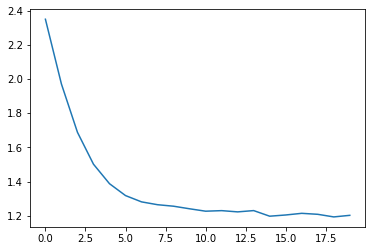

In [80]:
# print(total_loss)
plt.figure()
# print(all_losses)
plt.plot(all_losses)

## Sampling - The Fun Stuff
Now that we have created a language model based on the dog names, we can sample from it to generate new names.

In [81]:
def sample(start_letter):
    with torch.no_grad():
        iput = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        max_iters = 0
        
        while max_iters<30:
            output, hidden = rnn(iput[0], hidden)
            #select from the outputs according to the probability distribution
            probs = np.exp(output.detach().cpu().numpy()).ravel()
            ix_choice = np.random.choice(len(probs), p=probs)
            if ix_choice == char_to_ix['\n']:
                break
            else:
                letter = ix_to_char[ix_choice]
                output_name += letter
                max_iters+=1
    return output_name

In [82]:
sample('b')

'bajwl'

In [83]:
sample('f')

'frihvye'

In [84]:
sample('p')

'peppprsrt'

In [85]:
sample('a')

'absu'

In [94]:
sample('Ru')

'Ruok'

In [99]:
sample('cl')

'clostoviya'

In [100]:
sample('Beav')

'Beavakcry'

In [108]:
sample('Loo')

'Looti'

In [90]:
sample('honey')

'honeyuoee'

Far from perfect, but definitely in the right direction.